###**Alumnas**
      Guadalupe Solé

      Analía Cura Caram

##Readme
Este trabajo se abordó siguiendo la documentación citada en https://www.physionet.org/content/mitdb/1.0.0/

Acorde a como allí se solicita, se cita la fuente de información:

*Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.*

#Paso 1 - Dataset

Documentación wfdb https://physionet.org/content/wfdb-python/3.4.1/

In [ ]:
!pip install wfdb #Instalamos el paquete wfdb para poder manejar los waveform

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 945.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 29.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


##1.1 Importamos el dataset

In [ ]:
import wfdb
waveform_db = 'mitdb'

In [ ]:
subjects = wfdb.get_record_list(waveform_db)
print(f"La '{waveform_db}' base de datos contiene {len(subjects)} muestras")
print(f"Ejemplos de registros: {subjects[:5]}")

La 'mitdb' base de datos contiene 48 muestras
Ejemplos de registros: ['100', '101', '102', '103', '104']


###Exploración del dataset

In [ ]:
record = wfdb.rdrecord('100', pn_dir='mitdb') ## Carga el registro 100 desde la base MITDB
record

In [ ]:
print("Frecuencia de muestreo:", record.fs)  # frecuencia de muestreo
print("Nombres de los canales:", record.sig_name)  # nombres de los canales
print("Dimensión de la señal:", record.p_signal.shape)  # dimensión de la señal

Frecuencia de muestreo: 360
Nombres de los canales: ['MLII', 'V5']
Dimensión de la señal: (650000, 2)


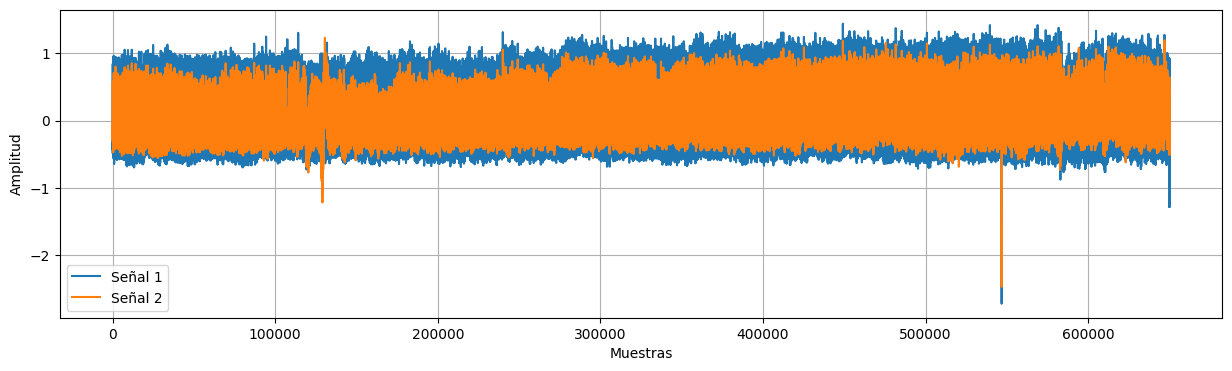

In [ ]:
#Graficamos el registro 100
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))
for i in range(record.p_signal.shape[1]):
    plt.plot(record.p_signal[:, i], label=f'Señal {i+1}')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()


#Paso 2 - Preprocesamiento

1. Nos enfocamos solo en 3 clases: 'N' → Latido normal (Normal beat). 'V' → Contracción ventricular prematura (PVC),'A' → Latido supraventricular prematuro (APB), descartando otros tipos de latidos
2. Recorremos cada registro de la base MIT-BIH; se filtra toda la señal usando un filtro Butterworth pasa-bajos de 40 Hz para reducir el ruido.  https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
3. Segmentación: Se corta una ventana de 200 milisegundos (72 muestras) alrededor del pico. Se extrae solo la señal que rodea al evento cardíaco.
4. Normalización: Cada ventana segmentada se normaliza: Media = 0, Desviación estándar = 1; de esta forma quedan los latidos comparables entre si.
Cada latido filtrado, segmentado y normalizado se guarda en un DataFrame (df)



##2.1/2.2 Filtrado y Segmentación

In [ ]:
## 1. Instalamos e importamos librerías
import numpy as np
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
import pandas as pd


In [ ]:
# 2. Definimos parámetros
#waveform_db = 'mitdb'
clases_interes = ['N', 'V', 'A']  # Nos quedamos solo con las clases de interés
fs = 360  # Definimos la frecuencia de muestreo (Hz)
ventana_muestras = int(0.2 * fs)  # 0.2 segundos alrededor del pico R. * 360 Hz frecuencia = 72 muestras
mitad_ventana = ventana_muestras // 2

In [ ]:
# 3. Definimos funciones
def butter_lowpass_filter(data, cutoff=40, fs=360, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def normalizar_latido(latido):
    return (latido - np.mean(latido)) / np.std(latido)

# 4. Obtenemos lista de registros
lista_registros = wfdb.get_record_list(waveform_db)
print(f"La base de datos '{waveform_db}' contiene {len(lista_registros)} registros.")

# 5. Inicializamos lista para guardar latidos
data = []

# 6. Recorremos registros
for registro in lista_registros:
    print(f"Procesando registro: {registro}...")

    # Carga la señal y anotaciones
    record = wfdb.rdrecord(registro, pn_dir='mitdb')
    annotation = wfdb.rdann(registro, 'atr', pn_dir='mitdb')

    signal = record.p_signal[:, 0]  #Canal principal

    # Filtramos la señal completa una sola vez
    signal_filtrada = butter_lowpass_filter(signal, cutoff=40, fs=360)

    # Recorremos latidos anotados
    for index, label in zip(annotation.sample, annotation.symbol):
        if label in clases_interes:
            inicio = index - mitad_ventana
            fin = index + mitad_ventana
            if inicio >= 0 and fin <= len(signal_filtrada):
                # Segmentamos ventana de 200ms
                latido = signal_filtrada[inicio:fin]

                # Normalizamos el latido
                latido_normalizado = normalizar_latido(latido)

                # Guarda el  latido
                data.append({
                    'record': registro,
                    'sample': index,
                    'label': label,
                    'signal_normalizada': latido_normalizado
                })

# 7. Creamos el DataFrame
df = pd.DataFrame(data)

print(f"\n Procesamiento completo: {len(df)} latidos segmentados, filtrados y normalizados.")
df.head()


La base de datos 'mitdb' contiene 48 registros.
Procesando registro: 100...
Procesando registro: 101...
Procesando registro: 102...
Procesando registro: 103...
Procesando registro: 104...
Procesando registro: 105...
Procesando registro: 106...
Procesando registro: 107...
Procesando registro: 108...
Procesando registro: 109...
Procesando registro: 111...
Procesando registro: 112...
Procesando registro: 113...
Procesando registro: 114...
Procesando registro: 115...
Procesando registro: 116...
Procesando registro: 117...
Procesando registro: 118...
Procesando registro: 119...
Procesando registro: 121...
Procesando registro: 122...
Procesando registro: 123...
Procesando registro: 124...
Procesando registro: 200...
Procesando registro: 201...
Procesando registro: 202...
Procesando registro: 203...
Procesando registro: 205...
Procesando registro: 207...
Procesando registro: 208...
Procesando registro: 209...
Procesando registro: 210...
Procesando registro: 212...
Procesando registro: 213...


,record,sample,label,signal_normalizada
0,100,77,N,"[-0.17504421282272326, -0.19625489086030337, -..."
1,100,370,N,"[-0.23200841162970964, -0.2494858758008039, -0..."
2,100,662,N,"[-0.1567195110893991, -0.17187565915303105, -0..."
3,100,946,N,"[-0.21443264432483597, -0.21977948223713925, -..."
4,100,1231,N,"[-0.15710505667095678, -0.17105148574416354, -..."


In [ ]:
df.shape

(84724, 4)

In [ ]:
df['label'].value_counts()

,count
label,
N,75048
V,7130
A,2546


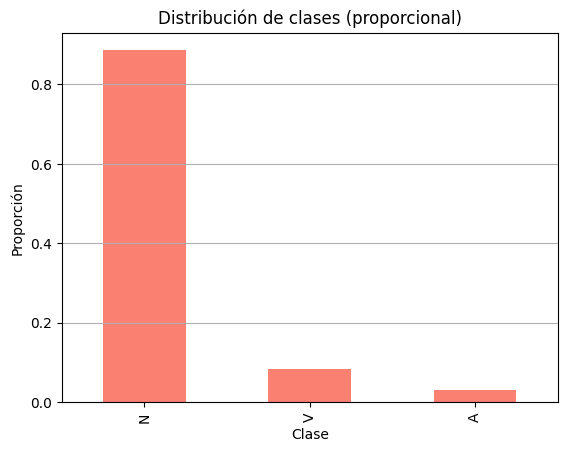

In [ ]:
df['label'].value_counts(normalize=True).plot(kind='bar', color='salmon')
plt.title('Distribución de clases (proporcional)')
plt.ylabel('Proporción')
plt.xlabel('Clase')
plt.grid(axis='y')
plt.show()

El dataset tiene un desbalance severo, la clase mayoritaria (N) representa casi el 90%, esto puede:

Sesgar el entrenamiento del modelo.

Generar alta accuracy pero con malas métricas para clases minoritarias.

Causar que el modelo “ignore” las clases menos frecuentes.

##2.3 División de datos
•	70% entrenamiento, 15% validación, 15% test (mezcla aleatoria).


In [ ]:
# 1. preparamos X e y
X = np.vstack(df['signal_normalizada'].values)  # Señales
y = df['label'].values                          # Etiquetas

# 2. dividimos en entrenamiento, validación y test
from sklearn.model_selection import train_test_split

# Primera división: entrenamiento (70%) y "restante" (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Segunda división: validación (15%) y test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Mostramos tamaños
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de validación: {X_val.shape[0]}")
print(f"Tamaño del conjunto de test: {X_test.shape[0]}")


Tamaño del conjunto de entrenamiento: 59306
Tamaño del conjunto de validación: 12709
Tamaño del conjunto de test: 12709


#Paso 3 - Modelado

##3.1 Red Prealimentada (MLP)

###Definición de la arquitectura

In [ ]:
#Convertimos las etiquetas a enteros para que puedan ser compiladas por sparse_categorical_crossentropy
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)

In [ ]:
#1. Importamos las librerías necesarias
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

Red neuronal **Perceptron Multicapa (MLP)** densa (fully connected) con dos capas ocultas y una de salida.

Arquitectura:

**Capa Dense** (64 neuronas, activación ReLU)
Esta primera capa procesa directamente el vector de entrada (el latido completo, ya segmentado y normalizado). Tiene 64 neuronas que aprenden representaciones abstractas del latido.

**Dropout** (tasa 0.3)
Se aplica para prevenir el sobreajuste desactivando aleatoriamente el 30% de las neuronas durante el entrenamiento.

**Capa Dense** (32 neuronas, activación ReLU)
Segunda capa densa, con menos neuronas, que permite capturar combinaciones más refinadas de las características detectadas por la capa anterior.

**Dropout** (tasa 0.3)
Refuerza la regularización antes de la salida.

**Capa Dense** (3 neuronas, activación softmax)
Capa de salida, con una neurona por clase (N, V, A), usando softmax para obtener la probabilidad de pertenencia a cada clase.



In [ ]:
# 2. Definimos la arquitectura de 2 capas densas
def crear_modelo():
  model = Sequential([
      Dense(64, activation='relu', input_shape=(ventana_muestras,)),
      #Añadimos regulación dropout "apagando" el 30% de las neuronas de la capa anterior (valor intermedio entre 0.2 y 0.5 que son los valores habituales)
      #De esta forma evitamos un posible overfitting en arquitecturas con capas densas
      Dropout(0.3),
      Dense(32, activation='relu'),
      Dropout(0.3),
      Dense(3, activation='softmax')  # Probabilidad para las 3 clases: N, V, A
  ])
  return model

###Entrenamiento

Los optimizadores elegidos fueron Adam (Adaptive Moment Estimation) y SGD (Stochastic Gradient Descent).
 - Adam es recomendable por su velocidad de convergencia y adaptabilidad, especialmente útil cuando se trabaja con pulsos variables o ruido.
 - Adam tiene la capacidad para adaptar dinámicamente la tasa de aprendizaje durante el entrenamiento, crucial en este conjunto de datos que cuenta con clases desbalanceadas
 - SGD es un optimizador simple, robusto y ampliamente probado, especialmente útil cuando se desea un control fino del aprendizaje.



https://keras.io/api/optimizers/adam/

https://keras.io/api/optimizers/sgd/


In [ ]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Callback para detener el entrenamiento si no hay mejora en la validación durante 5 épocas
early_stop = EarlyStopping(
    monitor='val_loss',     # Métrica a monitorear
    patience=5,             # Número de épocas sin mejora antes de detener
    restore_best_weights=True # Recupera los pesos de la mejor época
)

model_adam = crear_modelo()
model_adam.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

start_adam = time.time()
history_adam = model_adam.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=0,
    callbacks=[early_stop]  # Agregamos EarlyStopping
)
end_adam = time.time()
tiempo_adam = end_adam - start_adam


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
import time
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_sgd = crear_modelo()
optimizer_sgd = SGD(learning_rate=0.01, momentum=0.9)
model_sgd.compile(optimizer=optimizer_sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

start_sdg = time.time()
history_sgd = model_sgd.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=0,
    callbacks=[early_stop]
)
end_sdg = time.time()
tiempo_sdg = end_sdg - start_sdg

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 3.2 Red Convolucional (CNN)

El modelo **model_cnn** es una red neuronal convolucional unidimensional (Conv1D).

**Capa Conv1D** (32 filtros, tamaño de ventana 5, activación ReLU): Esta capa realiza la convolución unidimensional sobre los datos de entrada. Los 32 filtros indican que se extraerán 32 características diferentes de la secuencia de entrada. La activación ReLU (Rectified Linear Unit) se utiliza para introducir no linealidad en la salida de esta capa.

**Capa MaxPooling1D** (tamaño 2): Después de cada capa Conv1D, se aplica una capa de MaxPooling1D para reducir la longitud de la secuencia. En este caso, el tamaño 2 indica que se reducirá la longitud de la secuencia a la mitad.

**Capa Conv1D** (64 filtros, tamaño de ventana 5, activación ReLU): Esta es otra capa Conv1D que sigue a la primera capa de MaxPooling1D. Tiene 64 filtros para extraer características más complejas de las características ya extraídas por la capa anterior.

**Capa MaxPooling1D** (tamaño 2): Similar a la primera capa de MaxPooling1D, esta capa reduce la longitud de la secuencia a la mitad nuevamente después de la segunda capa Conv1D.

**Capa Flatten**: Esta capa se utiliza para aplanar los datos 3D (en este caso, los datos de salida de las capas de MaxPooling1D) en un vector 1D. Esto es necesario antes de pasar los datos a las capas densamente conectadas (Dense).

**Capa Dense** (64 neuronas, activación ReLU): Una capa densamente conectada con 64 neuronas y activación ReLU. Esta capa procesa las características extraídas y aprendidas por las capas convolucionales y de pooling.

**Capa Dense** (3 neuronas, activación softmax): Capa de salida con 3 neuronas, una para cada clase (N, V, A). La activación softmax se utiliza aquí para calcular la probabilidad de que cada muestra pertenezca a cada una de las clases.

In [ ]:
import wfdb
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

###Definición de la arquitectura

In [ ]:
def crear_modelo_cnn():
  model_cnn = Sequential([
      Conv1D(32, 5, activation='relu', input_shape=(ventana_muestras, 1)),  # Primera capa Conv1D
      MaxPooling1D(2),  # Capa de MaxPooling1D para reducir la longitud de la secuencia
      Conv1D(64, 5, activation='relu'),  # Segunda capa Conv1D
      MaxPooling1D(2),  # Otra capa de MaxPooling1D para reducir la longitud
      Flatten(),  # Aplanar los datos para la capa densa
      Dense(64, activation='relu'),  # Capa Dense con activación ReLU
      Dense(3, activation='softmax')  # Capa de salida para 3 clases: N, V, A con activación softmax
  ])
  return model_cnn

###Entrenamiento

Justificación de los optimizadores: Para el entrenamiento de la red CNN elegimos los optimizadores Adam (Adaptive Moment Estimation)y RMSprop (Root Mean Square Propagation). Ambos son bastante populares y hay mucha documentación de consulta. La elección se basa en su capacidad para adaptar dinámicamente la tasa de aprendizaje durante el entrenamiento. Este atributo es crucial en nuestro conjunto de datos, donde tenemos clases desbalanceadas, ya que permite que el modelo aprenda de manera efectiva de las clases minoritarias sin comprometer su habilidad para generalizar sobre las clases mayoritarias.

Durante el proceso de entrenamiento, realizamos varias iteraciones ajustando el tamaño del batch (batch size) entre 64, 128 y 256. Finalmente, el mejor rendimiento tanto en tiempo como en métricas, se obtuvo utilizando un tamaño de batch de 128.

In [ ]:
# Optimizador ADAMS
import time
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Compilar el modelo con Adam
model_adam_cnn = crear_modelo_cnn()
model_adam_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

start_adam_cnn = time.time()
history_adam_cnn = model_adam_cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128,
    verbose=0,
    callbacks=[early_stop]
)
end_adam_cnn = time.time()
tiempo_adam_cnn = end_adam_cnn - start_adam_cnn

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
import time
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

# EarlyStopping para prevenir sobreentrenamiento
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Crear y compilar el modelo
model_rms_cnn = crear_modelo_cnn()
model_rms_cnn.compile(optimizer=RMSprop(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Medir tiempo de entrenamiento
start_rmsprop_cnn = time.time()

history_rms_cnn = model_rms_cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128,
    verbose=0,
    callbacks=[early_stop]  # EarlyStopping agregado
)

end_rmsprop_cnn = time.time()
tiempo_rmsprop = end_rmsprop_cnn - start_rmsprop_cnn

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Para evitar el sobreajuste y optimizar el tiempo de entrenamiento, se aplicaron técnicas de regularización: Dropout fue utilizado únicamente en los modelos MLP, mientras que EarlyStopping se implementó en todos los modelos.
Esta última técnica permite interrumpir automáticamente el entrenamiento cuando la métrica de validación deja de mejorar, lo que contribuyó a reducir significativamente el tiempo de entrenamiento en los modelos CNN.

#Paso 4 - Evaluación

##4.1 - Evaluación Red Prealimentada (MLP)

In [ ]:
#Precisión general
loss_adam_mlp, acc_adam_mlp = model_adam.evaluate(X_test, y_test)
print(f"Accuracy general Adam: {acc_adam_mlp:.2%}")
print(f"Tiempo de entrenamiento con Adam: {tiempo_adam:.2f} segundos")

loss, acc = model_sgd.evaluate(X_test, y_test)
print(f"Accuracy general SDG: {acc:.2%}")
print(f"Tiempo de entrenamiento con SDG: {tiempo_sdg:.2f} segundos")

398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9806 - loss: 0.0653
Accuracy general Adam: 98.04%
Tiempo de entrenamiento con Adam: 207.68 segundos
398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9791 - loss: 0.0740
Accuracy general SDG: 97.80%
Tiempo de entrenamiento con SDG: 185.87 segundos


398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


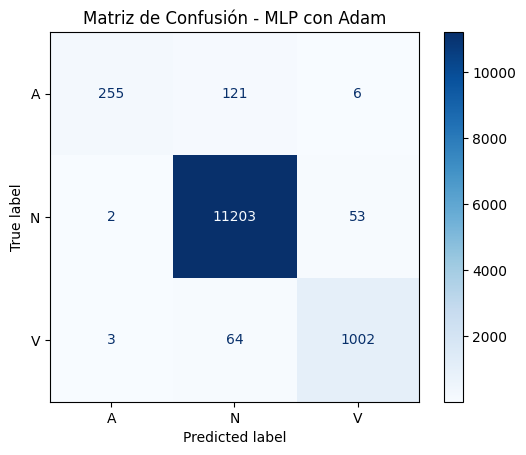

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.67      0.79       382
           1       0.98      1.00      0.99     11258
           2       0.94      0.94      0.94      1069

    accuracy                           0.98     12709
   macro avg       0.97      0.87      0.91     12709
weighted avg       0.98      0.98      0.98     12709



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Obtener predicciones del modelo (clase con mayor probabilidad)
y_pred_probs = model_adam.predict(X_test)
y_pred_adam_mlp = np.argmax(y_pred_probs, axis=1)

# Calcular la matriz de confusión
matriz = confusion_matrix(y_test, y_pred_adam_mlp)

# Mostrar la matriz gráficamente
disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=['A', 'N', 'V'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - MLP con Adam")
plt.show()
print("Classification Report:\n", classification_report(y_test, y_pred_adam_mlp))


398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


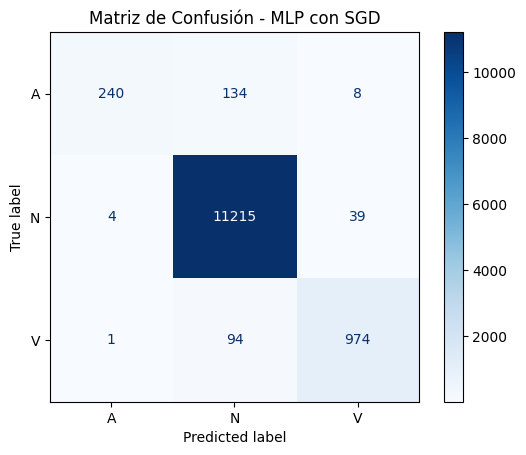

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.63      0.77       382
           1       0.98      1.00      0.99     11258
           2       0.95      0.91      0.93      1069

    accuracy                           0.98     12709
   macro avg       0.97      0.85      0.90     12709
weighted avg       0.98      0.98      0.98     12709



In [ ]:
# Obtener predicciones del modelo (clase con mayor probabilidad)
y_pred_probs = model_sgd.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calcular la matriz de confusión
matriz = confusion_matrix(y_test, y_pred)

# Mostrar la matriz gráficamente
disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=['A', 'N', 'V'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - MLP con SGD")
plt.show()
print("Classification Report:\n", classification_report(y_test, y_pred))


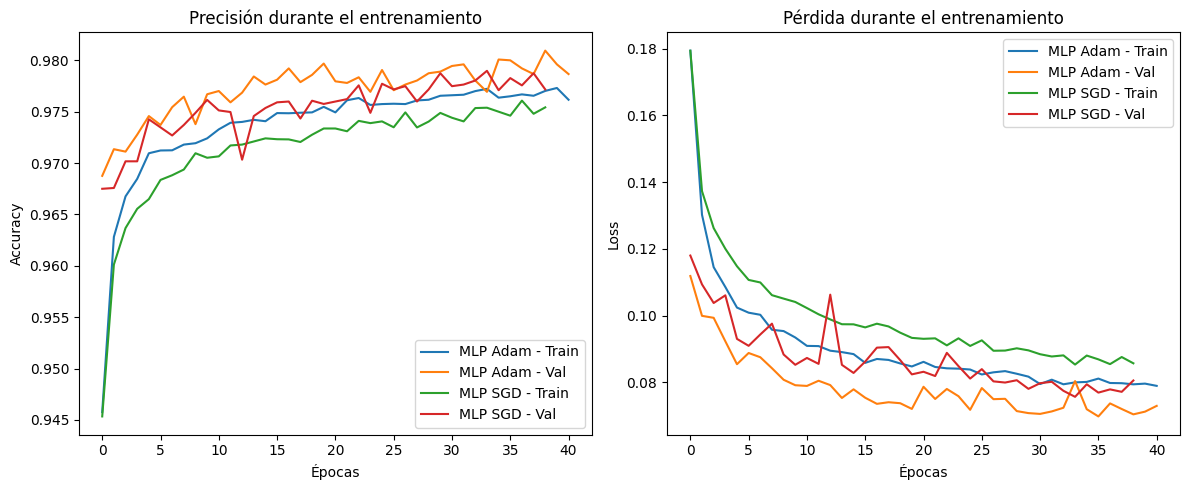

In [ ]:
#Graficamos la comparación entre ambos optimizadores (ADAM - SDG)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history_adam.history['accuracy'], label='MLP Adam - Train')
plt.plot(history_adam.history['val_accuracy'], label='MLP Adam - Val')
plt.plot(history_sgd.history['accuracy'], label='MLP SGD - Train')
plt.plot(history_sgd.history['val_accuracy'], label='MLP SGD - Val')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history_adam.history['loss'], label='MLP Adam - Train')
plt.plot(history_adam.history['val_loss'], label='MLP Adam - Val')
plt.plot(history_sgd.history['loss'], label='MLP SGD - Train')
plt.plot(history_sgd.history['val_loss'], label='MLP SGD - Val')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


##Conclusión MLP

Si bien Adam presenta mayor tiempo de procesamiento, ofrece un mejor desempeño global en términos de recall y F1-score, además de mayor precisión y menor pérdida en todas las épocas, esto lo convierte en la mejor opción comparado con SDG. Entre los hallazgos:


- Adam presenta menos errores de clasificación, especialmente en la clase minoritaria 'A'

- Adam muestra una menor pérdida de validación y entrenamiento durante casi todas las épocas, indicando mejor capacidad de generalización.

- Ambas curvas de validación muestran cierta fluctuación, pero las de Adam son más estables y presentan menos overfitting.
- En SDG  el entrenamiento fue más rápido pero menos estable.
- No hay evidencia de sobreajuste en ninguno de los dos modelos, probablemente vinculado al uso del regulador Dropout.

El optimizador Adam ofrece un mejor desempeño en términos de precisión y pérdida, mostrando una convergencia más eficiente y mayor capacidad de generalización frente a SGD.

##4.2 - Evaluación red Convolucional (CNN)

In [ ]:
loss_adam_cnn, acc_adam_cnn = model_adam_cnn.evaluate(X_test, y_test)
print(f"Accuracy general Adam para CNN: {acc_adam_cnn:.2%}")
print(f"Tiempo de entrenamiento con Adam para CNN: {tiempo_adam_cnn:.2f} segundos")

loss, acc = model_rms_cnn.evaluate(X_test, y_test)
print(f"Accuracy general RMSprp para CNN: {acc:.2%}")
print(f"Tiempo de entrenamiento con RMSprop para CNN: {tiempo_rmsprop:.2f} segundos")


398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9880 - loss: 0.0470
Accuracy general Adam para CNN: 98.77%
Tiempo de entrenamiento con Adam para CNN: 204.11 segundos
398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9870 - loss: 0.0527
Accuracy general RMSprp para CNN: 98.59%
Tiempo de entrenamiento con RMSprop para CNN: 123.70 segundos


398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


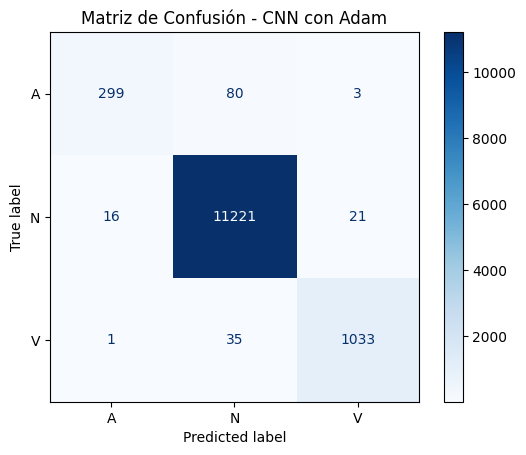

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.78      0.86       382
           1       0.99      1.00      0.99     11258
           2       0.98      0.97      0.97      1069

    accuracy                           0.99     12709
   macro avg       0.97      0.92      0.94     12709
weighted avg       0.99      0.99      0.99     12709



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtener predicciones del modelo (clase con mayor probabilidad)
y_pred_probs = model_adam_cnn.predict(X_test)
y_pred_adam_cnn = np.argmax(y_pred_probs, axis=1)

# Calcular la matriz de confusión
matriz = confusion_matrix(y_test, y_pred_adam_cnn)

# Mostrar la matriz gráficamente
disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=['A', 'N', 'V'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - CNN con Adam")
plt.show()
print("Classification Report:\n", classification_report(y_test, y_pred_adam_cnn))

398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


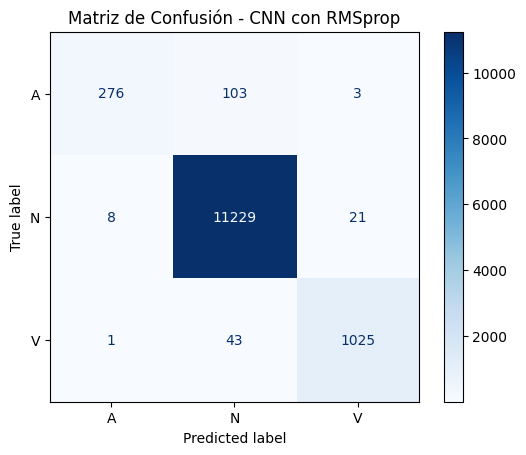

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.72      0.83       382
           1       0.99      1.00      0.99     11258
           2       0.98      0.96      0.97      1069

    accuracy                           0.99     12709
   macro avg       0.98      0.89      0.93     12709
weighted avg       0.99      0.99      0.99     12709



In [ ]:
# Obtener predicciones del modelo (clase con mayor probabilidad)
y_pred_probs = model_rms_cnn.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calcular la matriz de confusión
matriz = confusion_matrix(y_test, y_pred)

# Mostrar la matriz gráficamente
disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=['A', 'N', 'V'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - CNN con RMSprop")
plt.show()
print("Classification Report:\n", classification_report(y_test, y_pred))

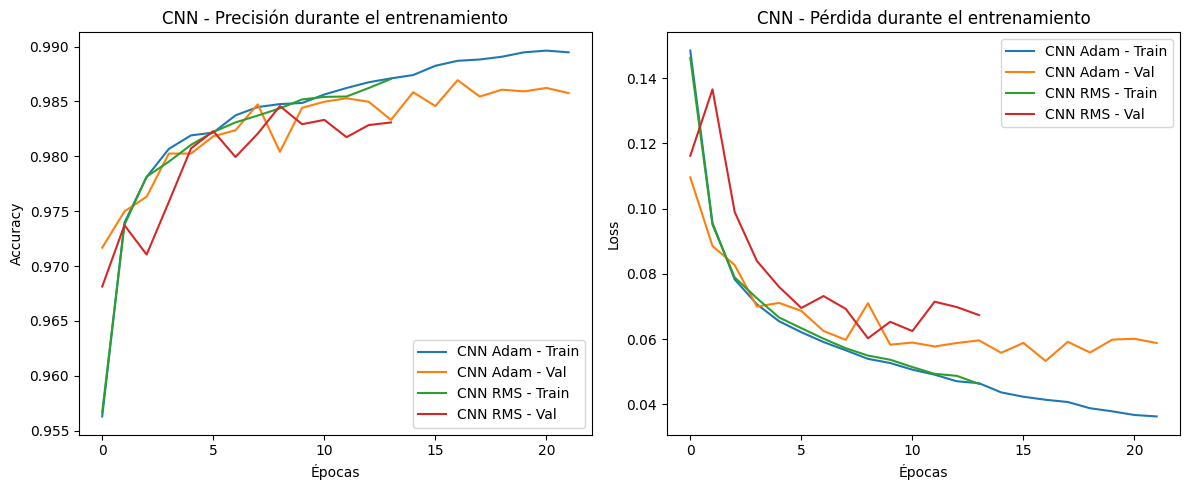

In [ ]:
#Graficamos la comparación entre ambos optimizadores con Batch Size = 128
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history_adam_cnn.history['accuracy'], label='CNN Adam - Train')
plt.plot(history_adam_cnn.history['val_accuracy'], label='CNN Adam - Val')
plt.plot(history_rms_cnn.history['accuracy'], label='CNN RMS - Train')
plt.plot(history_rms_cnn.history['val_accuracy'], label='CNN RMS - Val')
plt.title('CNN - Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history_adam_cnn.history['loss'], label='CNN Adam - Train')
plt.plot(history_adam_cnn.history['val_loss'], label='CNN Adam - Val')
plt.plot(history_rms_cnn.history['loss'], label='CNN RMS - Train')
plt.plot(history_rms_cnn.history['val_loss'], label='CNN RMS - Val')
plt.title('CNN - Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


##Conclusión CNN

Al igual que en MLP, Adam presenta un mayor tiempo de procesamiento, pero mejor desempeño en las métricas de recall y F1-Score. RMSprop puede ser útil si se busca un menor tiempo de procesamiento, pero Adam es preferible si se prioriza rendimiento y robustez del modelo.
-   Ambos modelos alcanzaron un accuracy de 0,99
-   El F1-score muestra resultados consistentes en ambas métricas, con ligeras variaciones, donde Adam tiene 0.94 frente a 0.93 de RSMprop.
-   Respecto a las curvas de validación muestran cierta fluctuación, pero las de Adam son más estables y presentan menos overfitting.
- RMSprop alcanza buen rendimiento, pero las fluctuaciones en la pérdida de validación sugieren una menor estabilidad. Podría ser indicio de ovefitting en etapas avanzadas del entrenamiento.


#Conclusión final

Para ambos modelos nos quedamos con el optimizador Adam que si bien tiene el tiempo de procesamiento mas alto, las metricas de accuracy, recall son buenas, demostrando robustez para clasificar las clases minoritarias, siendo que partimos de un dataset desbalanceado.

A continuación haremos una comparativa entre ambos modelos con los optimizadores elegidos, para poder quedarnos con uno como elección final.

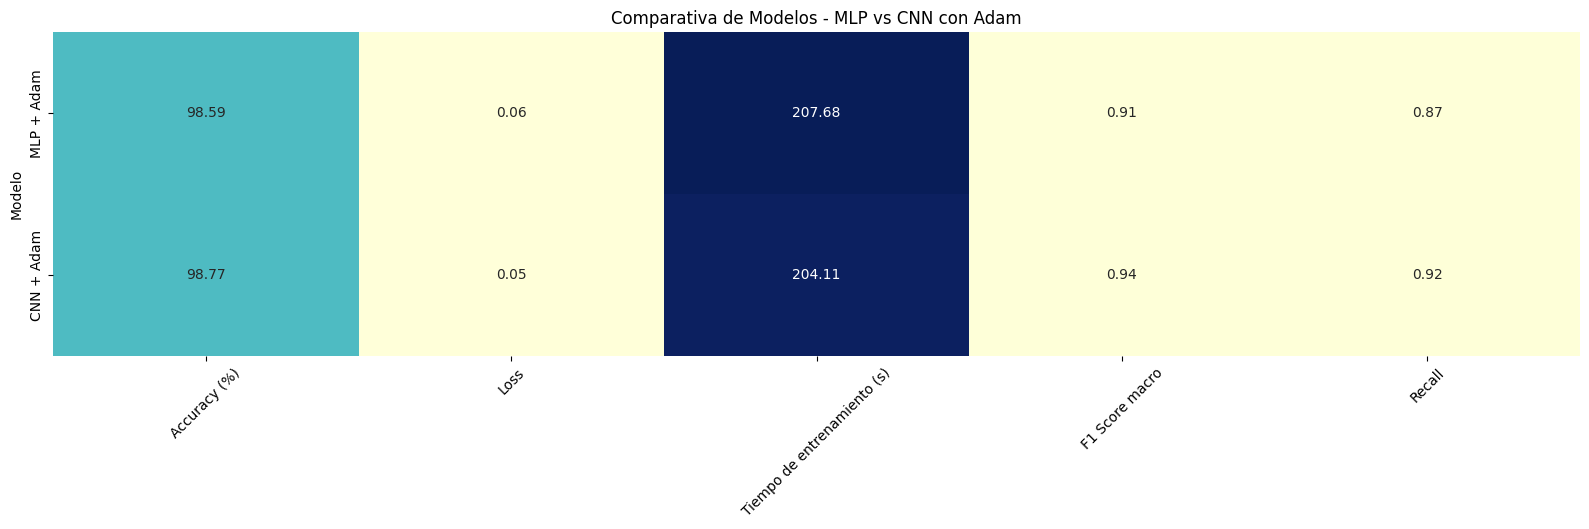

In [ ]:
resultados = {
    "Modelo": ["MLP + Adam", "CNN + Adam"],
    "Accuracy (%)": [acc_adam_mlp := acc * 100, acc_cnn := acc_adam_cnn * 100],
    "Loss": [loss_adam_mlp := loss, loss_adam_cnn := loss_adam_cnn],
    "Tiempo de entrenamiento (s)": [tiempo_adam, tiempo_adam_cnn],
    "F1 Score macro": [
        classification_report(y_test, y_pred_adam_mlp, output_dict=True)["macro avg"]["f1-score"],
        classification_report(y_test, y_pred_adam_cnn, output_dict=True)["macro avg"]["f1-score"]
    ],
    "Recall": [
        classification_report(y_test, y_pred_adam_mlp, output_dict=True)["macro avg"]["recall"],
        classification_report(y_test, y_pred_adam_cnn, output_dict=True)["macro avg"]["recall"]
    ]
}

df_comparativa = pd.DataFrame(resultados)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 4))
sns.heatmap(df_comparativa.set_index("Modelo"), annot=True, fmt=".2f", cmap="YlGnBu", cbar=False)
plt.title("Comparativa de Modelos - MLP vs CNN con Adam")
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

El modelo CNN + Adam tiene mejores métricas de F1 macro (0.94) y recall (0.92), lo que indica que clasifica mejor en promedio en todas las clases, especialmente en casos difíciles o desbalanceados.

MLP + Adam, aunque preciso, muestra menor recall (0.87), lo que sugiere que comete más falsos negativos, es decir, se le "escapan" más casos reales.

Si se busca máximo rendimiento predictivo y mejor cobertura por clase, CNN + Adam es la opción recomendada.

Dado el contexto, que estamos analizando un caso médico, en el que ser precisos e identificar correctamente las clases minoritarias, puede significar la diferencia entre la vida y la muerte; optaríamos sin dudarlo por elegir el modelo que priorice precisión por sobre costo computacional.

CNN+Adam es nuestra elección.